# HTS Course: DESeq2 Analysis Outline for 2017 Pilot Data

### Data Import

Load packages

In [7]:
library(tidyverse)
library(tools)
library(DESeq2)

In [39]:

cntdir<-"/home/jovyan/work/2017-HTS-materials/Data_Info_and_Results/2017_HTS/counts/HTS_2017_pilot"
cntfiles<-list.files(cntdir)
cntdf<-tibble(cntfiles,md5sum=tools::md5sum(file.path(cntdir,cntfiles)))
cntdf

cntfiles                           md5sum
1 Pst-kb1_S1.csv 7cab95ffd43eccabd4bff0f1e6b4ac5f
2 Pst-kb2_S2.csv 59633fe06424e54937c34a56c5e24477
3 Pst-kb3_S3.csv 2b576a5c270e7638b5072fa3776ecc83
4 Pst-mm1_S4.csv 072a43688309a087125c565c9f41cf54
5 Pst-mm3_S5.csv 3e255f6af17a313b6839a1f4f2595fdc
6 Pst-mm4_S6.csv dcac1408050aa686c7350d6a9b70d737

Identify the csv file containing the meta data

In [17]:
metafile<-"/home/jovyan/work/2017-HTS-materials/Data_Info_and_Results/2017_HTS/info/full_metadata.csv"
tools::md5sum(metafile)

/home/jovyan/work/2017-HTS-materials/Data_Info_and_Results/2017_HTS/info/full_metadata.csv 
                                                        "c2dddfedfd9107615ddf0d62f0c6453e"

Import the csv file

In [18]:
metadata<-read_csv(metafile)

Parsed with column specification:
cols(
  library_num = col_integer(),
  miseq_id = col_character(),
  miseq_filename = col_character(),
  nextseq_id = col_character(),
  nextseq_filename = col_character(),
  group = col_character(),
  genotype = col_character(),
  rna_prep = col_character(),
  rep = col_double(),
  media = col_character(),
  rin = col_double(),
  input_sample = col_character(),
  i7_index_id = col_character(),
  index = col_character(),
  notes = col_character()
)


Check the dimension annd first 6 rows of the of the imported file

In [4]:
dim(metadata)

[1] 54 15

In [5]:
head(metadata)

library_num miseq_id miseq_filename nextseq_id nextseq_filename group
1           1      1_A     1-A_S1.csv       JG-1     JG-L1_S1.csv     A
2           2      2_A     2-A_S2.csv       JG-2     JG-L2_S2.csv     A
3           3      3_A     3-A_S3.csv       JG-3     JG-L3_S3.csv     A
4           4      4_A     4-A_S4.csv       JG-4     JG-L4_S4.csv     A
5           5      5_A     5-A_S5.csv       JG-5     JG-L5_S5.csv     A
6           6      6_A     6-A_S6.csv       JG-6     JG-L6_S6.csv     A
  genotype rna_prep rep media rin input_sample i7_index_id    index notes
1      Pst      new   1    kb  10  Pst-kb1-new      P49-E1 AAGACCGT  <NA>
2      Pst      new   2    kb  10  Pst-kb2-new      P50-E2 TTGCGAGA  <NA>
3      Pst      new   3    kb  10  Pst-kb3-new      P51-E3 GCAATTCC  <NA>
4      Pst      new   1    mm  10  Pst-mm1-new      P52-E4 GAATCCGT  <NA>
5      Pst      new   2    mm  10  Pst-mm2-new      P53-E5 CCGCTTAA  <NA>
6      Pst      new   3    mm  10  Pst-mm3-new      P54-E6 TACCTGCA  <NA>

The group column can be used to subset the metadata

In [19]:
table(metadata$group,exclude=NULL)


    A     B     C     D     E     F     G     H pilot  <NA> 
    6     6     6     6     6     6     6     6     6     0 

We will look at the Pilot data

In [20]:
mydata <- metadata %>% filter(group=="pilot") 

In [9]:
mydata

library_num   miseq_id miseq_filename nextseq_id nextseq_filename group
1          49 Pst-kb1_S1 Pst-kb1_S1.csv       <NA>             <NA> pilot
2          50 Pst-kb2_S2 Pst-kb2_S2.csv       <NA>             <NA> pilot
3          51 Pst-kb3_S3 Pst-kb3_S3.csv       <NA>             <NA> pilot
4          52 Pst-mm1_S4 Pst-mm1_S4.csv       <NA>             <NA> pilot
5          53 Pst-mm3_S5 Pst-mm3_S5.csv       <NA>             <NA> pilot
6          54 Pst-mm4_S6 Pst-mm4_S6.csv       <NA>             <NA> pilot
  genotype rna_prep rep media rin input_sample i7_index_id    index notes
1      Pst      old   1    kb 8.4  Pst-kb1-old       P1-A1 TTACCGAC  <NA>
2      Pst      old   2    kb 9.0  Pst-kb2-old       P2-A2 AGTGACCT  <NA>
3      Pst      old   3    kb 8.7  Pst-kb3-old       P3-A3 TCGGATTC  <NA>
4      Pst      old   1    mm 7.9  Pst-mm1-old       P4-A4 CAAGGTAC  <NA>
5      Pst      old   3    mm 6.3  Pst-mm3-old       P5-A5 TCCTCATG  <NA>
6      Pst      old   4    mm 7.7  Pst-mm4-old       P6-A6 GTCAGTCA  <NA>

To create a sample data frame for DESeq2, be sure that the first and second columns are the sample and file name respectively

In [46]:
sampledata<- mydata %>% transmute(sampname=input_sample, 
                                  fname=miseq_filename, 
                                  trt=as.factor(media), 
                                  genotype, 
                                  group, 
                                  rna_prep,md5=md5sum(file.path(cntdir,miseq_filename))) %>% as.data.frame

In [32]:
sampledata

sampname          fname trt genotype group rna_prep
1 Pst-kb1-old Pst-kb1_S1.csv  kb      Pst pilot      old
2 Pst-kb2-old Pst-kb2_S2.csv  kb      Pst pilot      old
3 Pst-kb3-old Pst-kb3_S3.csv  kb      Pst pilot      old
4 Pst-mm1-old Pst-mm1_S4.csv  mm      Pst pilot      old
5 Pst-mm3-old Pst-mm3_S5.csv  mm      Pst pilot      old
6 Pst-mm4-old Pst-mm4_S6.csv  mm      Pst pilot      old
                               md5
1 7cab95ffd43eccabd4bff0f1e6b4ac5f
2 59633fe06424e54937c34a56c5e24477
3 2b576a5c270e7638b5072fa3776ecc83
4 072a43688309a087125c565c9f41cf54
5 3e255f6af17a313b6839a1f4f2595fdc
6 dcac1408050aa686c7350d6a9b70d737

## Overview of analysis

Import data as a DESeqData object

In [50]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable = sampledata, directory =cntdir, design=~trt )

Estimate and inspect size factors for the libraries

In [51]:
dds<-estimateSizeFactors(dds)

In [52]:
sizeFactors(dds)

Pst-kb1-old Pst-kb2-old Pst-kb3-old Pst-mm1-old Pst-mm3-old Pst-mm4-old 
  1.5559206   1.3861044   1.0377508   0.5033969   1.4562412   0.6772789

Estimate gene specific dispersions

In [53]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Conduct differential expression analysis

In [54]:
ddsDE<-DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [59]:
myres<-results(ddsDE)
myres

log2 fold change (MAP): trt mm vs kb 
Wald test p-value: trt mm vs kb 
DataFrame with 5842 rows and 6 columns
             baseMean log2FoldChange     lfcSE        stat       pvalue
            <numeric>      <numeric> <numeric>   <numeric>    <numeric>
PSPTOA0001  51.383556      1.1074926 0.2955247   3.7475462  0.000178573
PSPTOA0002  15.437549      0.4056040 0.4615707   0.8787473  0.379538281
PSPTOA0003   5.172905     -0.5142773 0.6847216  -0.7510751  0.452607434
PSPTOA0004  35.440383      0.9753153 0.3390883   2.8762869  0.004023838
PSPTOA0005  12.558815      0.5673048 0.4668771   1.2151051  0.224326014
...               ...            ...       ...         ...          ...
PSPTO_t59   0.3895036     0.57087886 1.1528334  0.49519631 6.204616e-01
PSPTO_t60   1.9232968    -1.93855730 1.0311783 -1.87994381 6.011574e-02
PSPTO_t61   0.1606037    -0.06597916 1.0382954 -0.06354566 9.493320e-01
PSPTO_t62  19.3487956    -3.66099758 0.6020517 -6.08086929 1.195327e-09
PSPTO_t63  19.2699434    -

Graphical over of the results

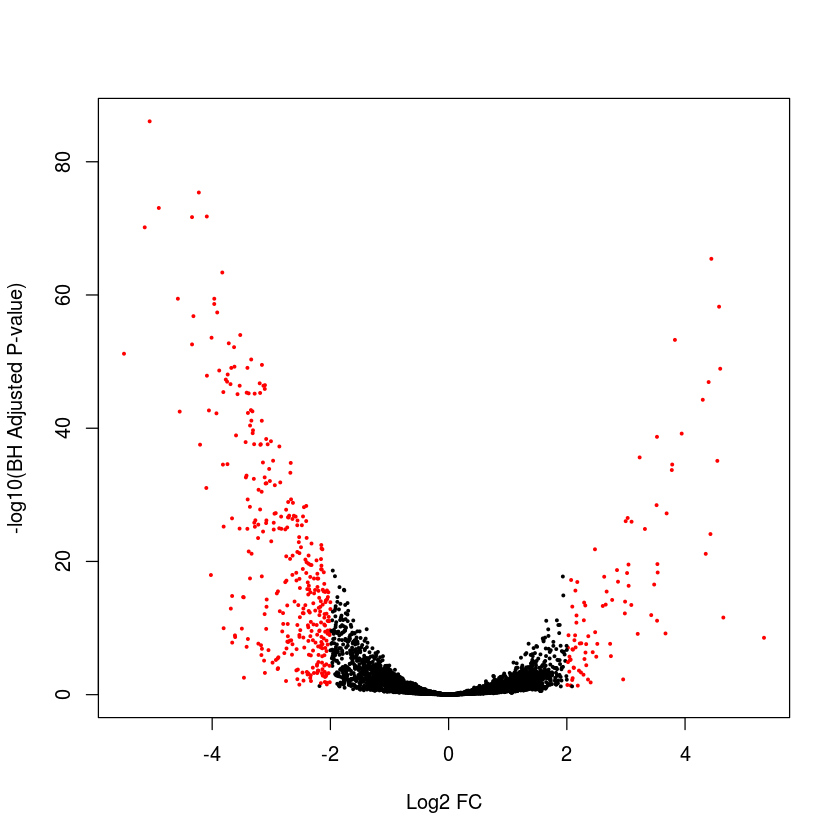

In [61]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)",col=ifelse(myres$padj<0.05&abs(myres$log2FoldChange)>2,"red","black"))

In [56]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] DESeq2_1.14.1              SummarizedExperiment_1.4.0
 [3] Biobase_2.34.0             GenomicRanges_1.26.4      
 [5] GenomeInfoDb_1.10.3        IRanges_2.8.2             
 [7] S4Vectors_0.12.2           BiocGenerics_0.20.0       
 [9] dplyr_0.5.0                purrr_0.2.2               
[11] readr_1.0.0                tidyr_0.6.0               
[13] tibble